# **Experiment 6**


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
color_palette = sns.color_palette()
plt.style.use('fivethirtyeight')

The Data taken for this experiment is Climate Data of Delhi City from the previous years and we will be doing time series analysis on various climate related variables

In [ ]:
df = pd.read_csv("DailyDelhiClimateTrain.csv") 
df.set_index("date", inplace=True)
df.index = pd.to_datetime(df.index)

In [ ]:
df.head(3)

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.5,0.000000,1015.666667
2013-01-02,7.400000,92.0,2.980000,1017.800000
2013-01-03,7.166667,87.0,4.633333,1018.666667


Take a look at the various variables provided to us and note any trends/periodical behaviour.

Mean temperature

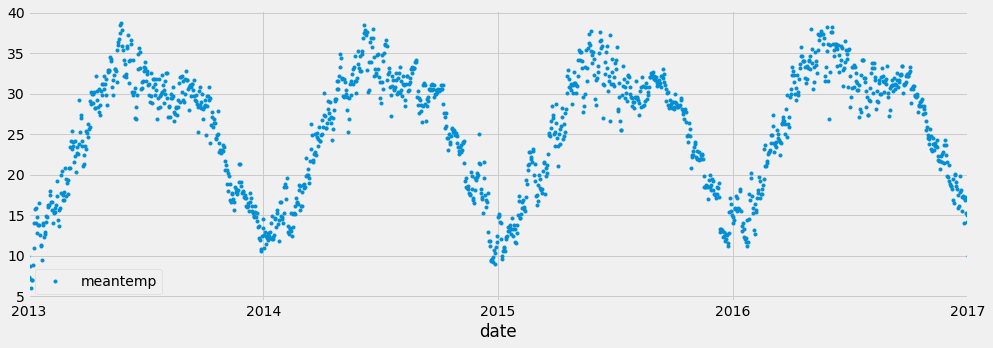

In [ ]:
df.plot(y='meantemp', figsize=(15, 5), style='.', color=color_palette[0])

This feature seems to vary periodically. As seen in the graph, this feature increases until reaching its maximum point for that year at May. It then declines with a small spike around September/October.

Humidity

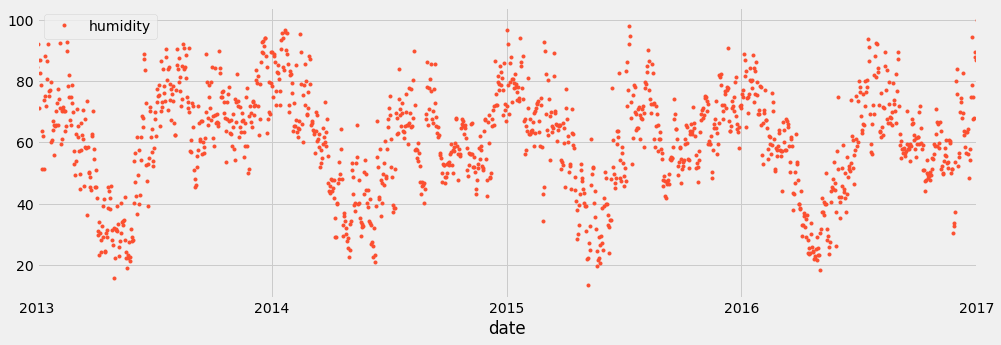

In [ ]:
df.plot(y='humidity', figsize=(15, 5), style='.', color=color_palette[1])

This feature steeply dips around February/March and increases, albeit with some turbulence, during the fall/winter seasons.

Wind Speed

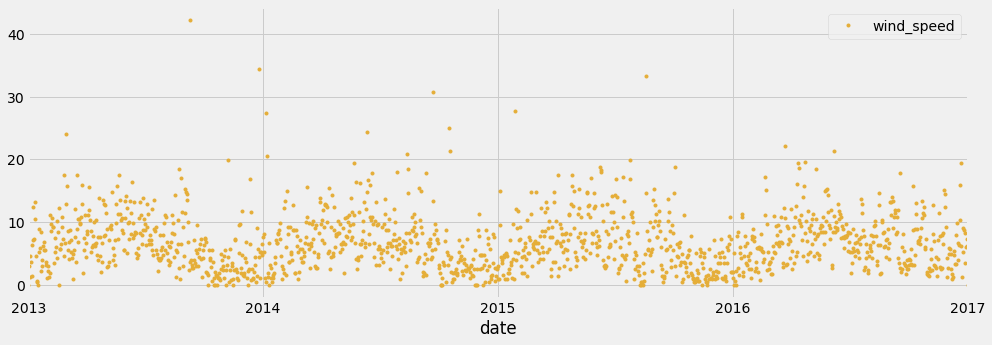

In [ ]:
df.plot(y='wind_speed', figsize=(15, 5), style='.', color=color_palette[2])

The `wind_speed` in Dehli doesn't vary too much. As depicted in the graph, the wind speed increases during late spring/early summer and then proceeds to return to its original value as the year comes to a close.

Mean Pressure

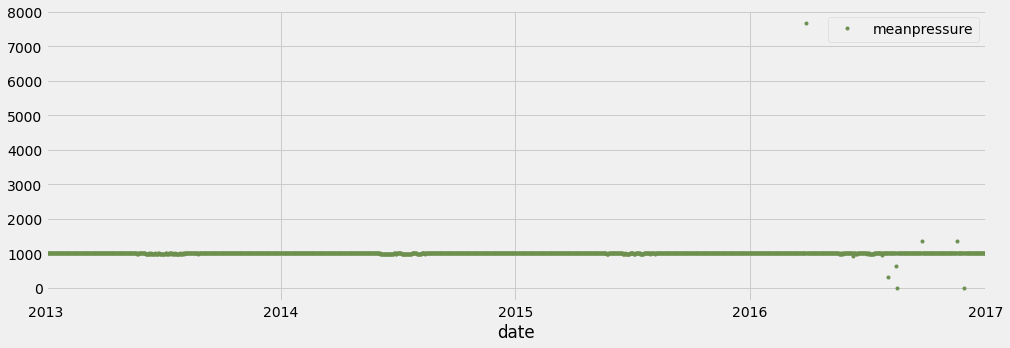

In [ ]:
df.plot(y='meanpressure', figsize=(15, 5), style='.', color=color_palette[3])

Aside from the occasional outlier, the mean pressure barely varies at all.

Week-by-week exploration

In this subsection, We observe the distribution of the values of each feature. Moreover, this subsection is intended to confirm the trends observed in the previous section


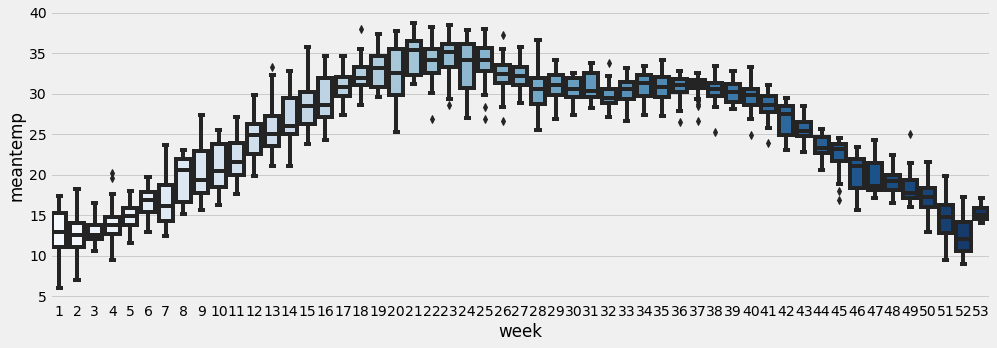

In [ ]:
df['week'] = df.index.isocalendar().week
plt.figure(figsize=(15, 5))
sns.boxplot(data=df, x='week', y='meantemp', palette='Blues')

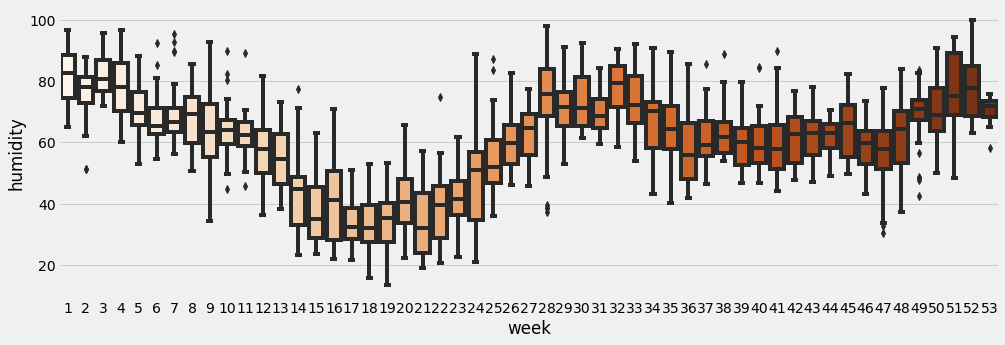

In [ ]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=df, x='week', y='humidity', palette='Oranges')

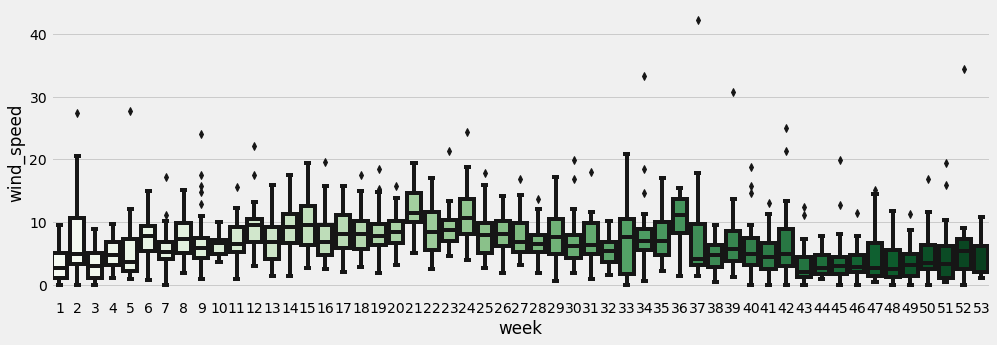

In [ ]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=df, x='week', y='wind_speed', palette='Greens')

This definitely confirms the trends present in first section; however, I do have one concern. The graph of the distribution of wind speed has a low amount of variation. This low variation might make this particular feature hard to predict. Although, I do not think this low variation will substantially affect the performance of the model we will create.

Creating a model to predict the values of `meantemp`, `humidity`, and `wind_speed`.

We'll start by doing some feature engineering. To keep things simple, I'll add two new features, namely `week` and `month`.

In [ ]:
def create_features(df):
    ret = df.copy()
    ret['week'] = ret.index.isocalendar().week
    ret['month'] = ret.index.month
    return ret

In [ ]:
df = create_features(df)
df.head(5)

,meantemp,humidity,wind_speed,meanpressure,week,month
date,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,1
2013-01-02,7.400000,92.000000,2.980000,1017.800000,1,1
2013-01-03,7.166667,87.000000,4.633333,1018.666667,1,1
2013-01-04,8.666667,71.333333,1.233333,1017.166667,1,1
2013-01-05,6.000000,86.833333,3.700000,1016.500000,1,1


## Train-Test Split

I'll use all dates before January 1, 2016 as my training set and all dates after January 1, 2016 as my test set.

In [ ]:
train = df.loc[df.index < '2016-01-01']
test = df.loc[df.index >= '2016-01-01']

Before moving on, let's visualize the train/test split.

The first function adjusts the changes the format of the DataFrame to something acceptable by XGBoost (the model we'll be using).

In [ ]:
def rectify_format(features, target, train=train, test=test):
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    X_train[features] = X_train[features].astype(np.int64)
    X_test[features] = X_test[features].astype(np.int64)
    
    return X_train, X_test, y_train, y_test

### Setup

In [ ]:
features = ['week', 'month']
target = 'meantemp'

In [ ]:
X_train, X_test, y_train, y_test = rectify_format(features, target, train, test)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Training

In [ ]:
mean_temp_reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
mean_temp_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:25.3169	validation_1-rmse:27.1944
[100]	validation_0-rmse:9.58052	validation_1-rmse:11.5129
[200]	validation_0-rmse:4.06541	validation_1-rmse:5.93867
[300]	validation_0-rmse:2.41263	validation_1-rmse:4.11609
[400]	validation_0-rmse:2.06098	validation_1-rmse:3.55946
[500]	validation_0-rmse:1.99524	validation_1-rmse:3.3965
[600]	validation_0-rmse:1.9794	validation_1-rmse:3.34394
[700]	validation_0-rmse:1.97268	validation_1-rmse:3.32881
[800]	validation_0-rmse:1.96913	validation_1-rmse:3.33117
[900]	validation_0-rmse:1.96678	validation_1-rmse:3.33623
[999]	validation_0-rmse:1.96499	validation_1-rmse:3.34194


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000,
             objective='reg:squarederror')

The root mean squared error is very low - a good sign.